#### Question 3

#### Question 3.1

In [1]:
import scipy.io as sio
import numpy as np
from scipy.stats import multivariate_normal as mvn
from scipy.linalg import eigh
import matplotlib.pyplot as plt

In [2]:
matFile = sio.loadmat("data.mat", squeeze_me=True)["data"]
print(f"{matFile.shape = }")

labels = sio.loadmat("label.mat", squeeze_me=True)["trueLabel"]
labels

matFile.shape = (784, 1990)


array([2, 2, 2, ..., 6, 6, 6], shape=(1990,), dtype=uint8)

In [3]:
m, n = (matFile.T).shape
m, n

(1990, 784)

In [4]:
# Covariance matrix
C = np.matmul(matFile, matFile.T) / m

# PCA the data
d = 4  # reduced dimension
values, v = eigh(C)
ind = np.argsort(values)[::-1][:d]
eigenval = values[ind]
v = v[:, ind]

In [5]:
# Project the data to the top 4 principal directions
pdata = np.dot(matFile.T, v)
pdata

array([[ 5.78589802,  1.86149301,  0.32208024, -4.02489803],
       [ 6.05737029,  2.32665249, -0.02495306,  2.19068824],
       [ 4.48984179,  1.25620196, -0.57603288, -2.1753182 ],
       ...,
       [ 5.01432062, -0.05119609,  3.140957  ,  0.34626446],
       [ 9.68151301, -2.11536692,  3.89177429, -1.35164814],
       [ 9.86028409, -3.52677095,  1.11889327,  0.62470281]],
      shape=(1990, 4))

In [6]:
# Code adapted from demo code
# Number of mixtures
K = 2

np.random.seed(123)

# Initialize prior
pi = np.random.random(K)
pi = pi / np.sum(pi)

# Initialize mean and covariance
mu = np.random.randn(K, 4)
mu_old = mu.copy()

sigma = []
for ii in range(K):
    dummy = np.random.randn(4, 4)
    sigma.append(dummy @ dummy.T + np.eye(4))

# Initialize the posterior
tau = np.full((m, K), fill_value=0.0)  # A matrix of dimension m x k filled with 0's

maxIter = 100
tol = 1e-3

# Log likelihood
log_like = []
iter = 0

for ii in range(maxIter):

    # E-step
    for kk in range(K):
        tau[:, kk] = pi[kk] * mvn.pdf(
            pdata, mean=mu[kk], cov=sigma[kk]
        )  # Un-normalized posterior

    sum_tau = tau.sum(axis=1)
    log_like.append(np.sum(np.log(sum_tau)))

    # Normalize posterior
    tau /= tau.sum(axis=1, keepdims=True)

    # M-step
    for kk in range(K):
        # Update prior
        pi[kk] = np.sum(tau[:, kk]) / m

        # Update component mean
        mu[kk] = np.dot(tau[:, kk].T, pdata) / np.sum(tau[:, kk])

        # Update cov matrix
        dummy = pdata - mu[kk]
        sigma[kk] = dummy.T @ np.diag(tau[:, kk]) @ dummy / np.sum(tau[:, kk], axis=0)

    iter += 1

    if np.linalg.norm(mu - mu_old) < tol:
        print(f"training converged at iteration {iter}")
        break

    mu_old = mu.copy()

    if ii == 99:
        print("max iteration reached")
        break

training converged at iteration 40


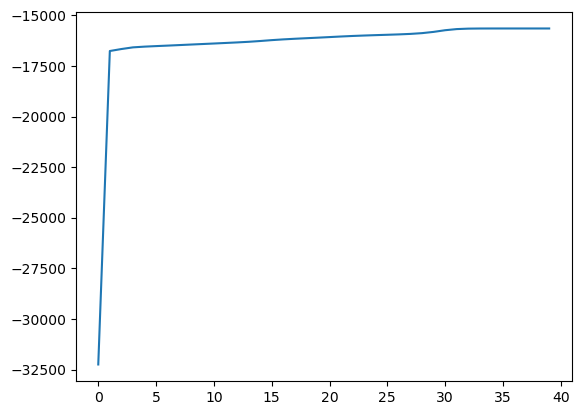

In [7]:
plt.plot(np.arange(iter), log_like)

#### Question 3.2

In [8]:
print(f"Weight for 1st component is {pi[0]}")
print(f"Weight for 2nd component is {pi[1]}")

Weight for 1st component is 0.4867800309445715
Weight for 2nd component is 0.5132199690554284


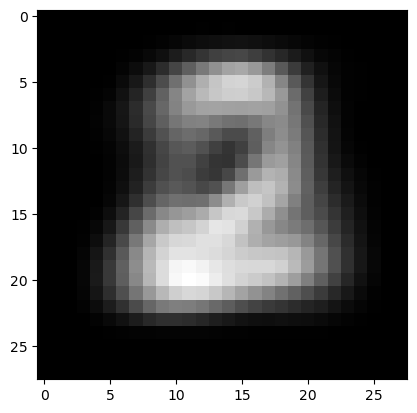

In [9]:
recon_mu_1 = v @ np.sqrt(np.diag(eigenval)) @ mu[0].reshape(-1, 1)

image1 = recon_mu_1.flatten().reshape(28, 28).T

plt.imshow(image1, cmap="gray")

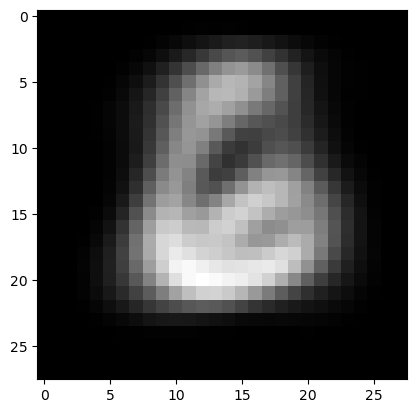

In [10]:
recon_mu_2 = v @ np.sqrt(np.diag(eigenval)) @ mu[1].reshape(-1, 1)

image2 = recon_mu_2.flatten().reshape(28, 28).T

plt.imshow(image2, cmap="gray")

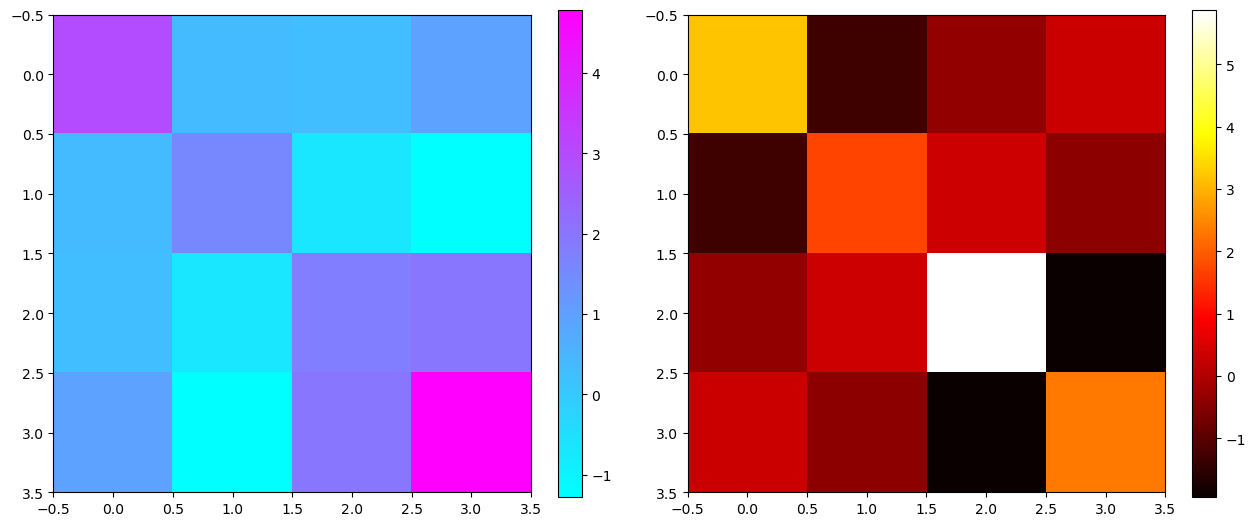

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
map_color = ["cool", "hot"]
for i in range(K):
    img = axs[i].imshow(sigma[i], cmap=map_color[i])
    fig.colorbar(img, ax=axs[i], fraction=0.046)

In [12]:
tau.shape
np.any(tau[:, 0] == 0.5)
np.any(tau[:, 1] == 0.5)
np.min(tau)

np.float64(5.362494887335746e-16)

#### Question 3.3

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

In [14]:
GMM_label = np.where(tau[:, 0] > tau[:, 1], 2, 6)

true_2_label = np.where(labels == 2)[0]
true_6_label = np.where(labels == 6)[0]

GMM_2_label = np.where(GMM_label == 2)[0]
GMM_6_label = np.where(GMM_label == 6)[0]

conf_matrix = confusion_matrix(GMM_label, labels)
print(conf_matrix)

print(f"{true_2_label.shape = }")
print(f"{true_6_label.shape = }")

print(f"{GMM_2_label.shape = }")
print(f"{GMM_6_label.shape = }")

[[966   9]
 [ 66 949]]
true_2_label.shape = (1032,)
true_6_label.shape = (958,)
GMM_2_label.shape = (975,)
GMM_6_label.shape = (1015,)


In [15]:
TP_2 = conf_matrix[0, 0]
FN_2 = conf_matrix[1, 0]
TN_2 = conf_matrix[1, 1]
FP_2 = conf_matrix[0, 1]
# Compute the misclassification rate for digit 2 class
misclass_rate_2 = (FN_2 + FP_2) / true_2_label.shape[0]
print(f"GMM: The misclassification rate for digit 2 class = {misclass_rate_2:.3f}")

# Compute the misclassification rate for digit 6 class
misclass_rate_6 = (FN_2 + FP_2) / true_6_label.shape[0]
print(f"GMM: The misclassification rate for digit 6 class = {misclass_rate_6:.3f}")

GMM: The misclassification rate for digit 2 class = 0.073
GMM: The misclassification rate for digit 6 class = 0.078


In [16]:
kmeans = KMeans(n_clusters=K).fit(pdata)
c_indx = kmeans.labels_
c_indx

array([1, 1, 1, ..., 1, 0, 0], shape=(1990,), dtype=int32)

In [17]:
kmeans_labels = np.where(c_indx == 1, 2, 6)

conf_matrix_2 = confusion_matrix(kmeans_labels, labels)
conf_matrix_2

array([[968,  76],
       [ 64, 882]])

In [18]:
TP_2 = conf_matrix_2[0, 0]
FN_2 = conf_matrix_2[1, 0]
TN_2 = conf_matrix_2[1, 1]
FP_2 = conf_matrix_2[0, 1]
# Compute the misclassification rate for digit 2 class
misclass_rate_2 = (FN_2 + FP_2) / true_2_label.shape[0]
print(f"KMeans: The misclassification rate for digit 2 class = {misclass_rate_2:.3f}")

# Compute the misclassification rate for digit 6 class
misclass_rate_6 = (FN_2 + FP_2) / true_6_label.shape[0]
print(f"KMeans: The misclassification rate for digit 6 class = {misclass_rate_6:.3f}")

KMeans: The misclassification rate for digit 2 class = 0.136
KMeans: The misclassification rate for digit 6 class = 0.146
